In [1]:
"""
jupyter-nbconvert report_ttcs.ipynb --to python; python -u report_ttcs.py

"""

'\njupyter-nbconvert report_ttcs.ipynb --to python; python -u report_ttcs.py\n\n'

In [2]:
from __future__ import division
import os
import glob
import pickle
from natsort import natsorted
import argparse
import os
import sys
import numpy as np
import tqdm
import pandas as pd

import scipy as sp
import numpy as np
from pprint import pprint
import glob
import sys
sys.path.append('../')
from plume_env import PlumeEnvironment, PlumeFrameStackEnvironment
import config
import agents
import agent_analysis
import os
import sklearn
import sklearn.decomposition as skld

import importlib
import log_analysis
importlib.reload(log_analysis)


<module 'log_analysis' from '../log_analysis.py'>

In [3]:
import sys
batchmode = False
if 'ipykernel_launcher' in sys.argv[0]:
    print("Interactive mode")
else:
    batchmode = True
    print("Batch/CLI mode")
    import argparse

Interactive mode


In [4]:
# Common
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches



import seaborn as sns
sns.set(style="white")
# print(plt.style.available)

mpl.rcParams['figure.dpi'] = 300
dpi_save = 300
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

# Interactive vs. CLI
if not batchmode:
    %matplotlib inline
    # %config InlineBackend.figure_format = 'svg'
    %config InlineBackend.figure_format = 'retina'
if batchmode:
    matplotlib.use("Agg")
    
pca3d_figsize=(10,5)

In [5]:
# Common
importlib.reload(config)
outcome_colormap = config.outcome_colormap
regime_colormap = config.regime_colormap

# https://seaborn.pydata.org/generated/seaborn.set_color_codes.html#seaborn.set_color_codes
sns.color_palette()
sns.set_color_codes(palette='deep')

In [6]:
if batchmode:
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('--model_fname', default=None)
#     parser.add_argument('--datasets', type=str, nargs='+',
#             default=['constantx5b5', 'switch45x5b5', 'noisy3x5b5'])
#     parser.add_argument('--dataset', type=str, default='constantx5b5')
    args = parser.parse_args()
    print(args)

    model_fname = args.model_fname

In [7]:
if not batchmode: # Interactive
    model_fname = natsorted(glob.glob(f'/home/satsingh/plume/plumezoo/latest/fly/memory/*VRNN*.pt'))[0]
#     model_fname = natsorted(glob.glob(f'/home/satsingh/plume/plumezoo/dynamic/fly/memory/*VRNN*.pt'))[0]



In [8]:
model_dir = model_fname.replace('.pt', '/')
print("model_dir", model_dir)

model_seed = model_dir.split('seed')[-1].split('/')[0]
print("model_seed ---->", model_seed)

outdir = f"{model_dir}/report_common_subspace/"
os.makedirs(outdir, exist_ok=True)
print(outdir)

is_recurrent = True if ('GRU' in model_dir) or ('VRNN' in model_dir) else False

logfiles = natsorted(glob.glob(model_dir + '*.pkl'))
[ x.split('/')[-1] for x in logfiles ]

model_dir /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed3307e9/
model_seed ----> 3307e9
/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed3307e9//report_common_subspace/


['constantx5b5.pkl',
 'constantx5b5_0.2.pkl',
 'constantx5b5_0.4.pkl',
 'constantx5b5_0.6.pkl',
 'constantx5b5_0.8.pkl',
 'noisy3x5b5.pkl',
 'noisy6x5b5.pkl',
 'switch15x5b5.pkl',
 'switch30x5b5.pkl',
 'switch45x5b5.pkl']

In [9]:
# use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy6x5b5']
use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']
selected_df = log_analysis.get_selected_df(model_dir, 
                              use_datasets, 
                              n_episodes_home=60, 
                              n_episodes_other=60,
                              min_ep_steps=0)
print(selected_df.shape)
selected_df

(298, 5)


,dataset,idx,ep_length,log,outcome
3,constantx5b5,82,285,"{'trajectory': [[6.089736038791369, 0.00960661...",HOME
7,constantx5b5,97,276,"{'trajectory': [[5.948685860931586, 0.05904046...",HOME
8,constantx5b5,102,275,"{'trajectory': [[5.942676230501777, 0.03266931...",HOME
9,constantx5b5,236,275,"{'trajectory': [[8.044839745325845, -0.4675270...",HOME
10,constantx5b5,92,275,"{'trajectory': [[5.991609051625939, 0.09911625...",HOME
...,...,...,...,...,...
319,noisy3x5b5,27,52,"{'trajectory': [[3.984323325354093, 0.58274205...",OOB
320,noisy3x5b5,33,52,"{'trajectory': [[4.034063828657129, 0.68613060...",OOB
321,noisy3x5b5,23,51,"{'trajectory': [[3.941389059537711, 0.73158124...",OOB
322,noisy3x5b5,100,50,"{'trajectory': [[5.941629538577946, 0.93596513...",OOB


In [10]:
selected_df.groupby(['dataset', 'outcome']).count()

idx  ep_length  log
dataset      outcome                     
constantx5b5 HOME      33         33   33
             OOB       33         33   33
noisy3x5b5   HOME      56         56   56
             OOB       56         56   56
switch45x5b5 HOME      60         60   60
             OOB       60         60   60

In [11]:
pca_common = log_analysis.get_pca_common(selected_df, 
                            n_comp=15, 
                            is_recurrent=is_recurrent)
with open(f"{outdir}/pca_common.pkl", 'wb') as file:
    pickle.dump(pca_common, file)

In [12]:
# # Plot neural-trajectories on common subspace
# # %matplotlib notebook 
# # importlib.reload(log_analysis)

# # %config InlineBackend.figure_format = 'retina' # For manuscript
# # mpl.rcParams['figure.dpi'] = 300

# column_to_titlestring = {
#     'odor_lastenc': 'Steps since last\nplume encounter',
#     'stray_distance': 'stray_distance', 
#     'odor_01': 'On/off plume',
#     'odor_ma_8': 'Odor moving-average\n(8 step window) [A.U.]',
#     'odor_ma_6': 'Odor moving-average\n(6 step window) [A.U.]',
#     'wind_theta_obs': 'Egocentric\nwind angle [rad]',
#     'agent_angle_ground': r'Head direction [rad]',
#     'turn': 'Turn',
#     'step': 'Step',
#     'neural_velocity': r"$\Delta$h",
# }

# column_ticklabels = {
#     'agent_angle_ground': [r'$-\pi/2$', 0, r'$+\pi/2$'],
# }

# column_ticks = {
#     'agent_angle_ground': [0, 0.5, 1.0],
# }



# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# def plot_common_subspace_all(selected_df, colorby):
#     fig = plt.figure(figsize=pca3d_figsize)
#     ax = fig.gca(projection='3d')

# #     plot_df = selected_df.groupby(['dataset', 'outcome']).head(5)
#     plot_df = selected_df.groupby(['dataset', 'outcome']).tail(5)
#     # plot_df = selected_df.groupby(['dataset', 'outcome']).sample(5, replace=True)

#     colorbar_is_plotted = False
#     for idx, row in plot_df.iterrows():
#         outcome = row['outcome']
#         ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
# #         ep_activity =  pd.DataFrame(ep_activity).diff().fillna(0).to_numpy() # if colorby == 'neural_velocity' else ep_activity

#         traj_df = log_analysis.get_traj_df(row['log'], 
#                    extended_metadata=True, 
#                    squash_action=True, 
#                    seed=model_seed)

#         X_pca = pca_common.transform(ep_activity)
# #         X_pca = pd.DataFrame(X_pca).diff().to_numpy()

#         ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], linewidth=0.6, c='grey', alpha=1.0)

#         if colorby == 'outcome':
#             sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=10, 
#                             c=outcome_colormap[outcome], label='outcome')
#         elif colorby == 'regime':    
#             regime_colors = [ regime_colormap[x] for x in traj_df['regime'] ]
#             sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=10, 
#                             c=regime_colors, alpha=0.5)
#         elif colorby in ['wind_theta_obs', 'agent_angle_ground']:  
#             # Cyclic colormap: https://matplotlib.org/stable/tutorials/colors/colormaps.html
#             # Seaborn: https://stackoverflow.com/questions/23712207/cyclic-colormap-without-visual-distortions-for-use-in-phase-angle-plots
#             c = traj_df[colorby]
#             print(colorby, c.min(), c.max())
#             sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
#                             s=10, c=c, cmap='twilight', alpha=0.5, vmin=0, vmax=1)
#         elif 'odor' in colorby:    
#             c = traj_df[colorby]
#             print(colorby, c.min(), c.max())
#             vmax = 28 if colorby == 'odor_lastenc' else 1
#             sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
#                             s=10, c=c, cmap='copper', alpha=0.5, vmin=0, vmax=vmax)

#         elif colorby == 'stray_distance':    
#             c = traj_df[colorby]
#             print(colorby, c.min(), c.max())
#             sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
#                             s=10, c=c, cmap='copper', alpha=0.5, vmin=0, vmax=2)
#         elif colorby in ['step', 'turn']:    
#             c = traj_df[colorby]
#             print(colorby, c.min(), c.max())
#             sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
#                             s=10, c=c, cmap='copper', alpha=0.5, vmin=0, vmax=1)
        
#         elif colorby == 'neural_velocity':    
#             c = pd.DataFrame(ep_activity).diff().fillna(0).apply(np.linalg.norm, axis=1)
# #             c /= pd.DataFrame(ep_activity).apply(np.linalg.norm, axis=1)
# #             c = np.log(1+c)
# #             c = np.clip(0, 1.5, c)
#             print(colorby, c.min(), c.max())
#             sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
#                             s=10, c=c, cmap='copper', alpha=0.5, vmin=0)
    
#         else:    
#             c = traj_df[colorby]
#             print(colorby, c.min(), c.max())
#             sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
#                             s=10, c=c, cmap='copper', alpha=0.5, vmin=0)

#     if not batchmode:
#         plt.title(f"{colorby} [{model_seed}]]")

#     # https://stackoverflow.com/questions/18211967/position-colorbar-inside-figure
#     if colorby not in ['outcome', 'regime']:
# #         plt.colorbar(sc)
#         cbar_ax = inset_axes(ax, 
#                              width="30%", 
#                              height="3%", 
# #                              loc='upper right',
#                              bbox_to_anchor=(0.0, 0.45, 0.92, 0.4), # (x0, y0, width, height)
#                              bbox_transform=ax.transAxes,
#                             )
#         clb = plt.colorbar(sc, cbar_ax, orientation='horizontal') # ticks=[0., 1.]
# #         cbar_ax.set_title(colorby)
#         cbar_ax.set_title(column_to_titlestring[colorby])
#         if colorby in column_ticklabels.keys():
#             clb.set_ticks(column_ticks[colorby])
#             clb.set_ticklabels(column_ticklabels[colorby])

#     # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
#     # divider = make_axes_locatable(ax)
#     # cax = divider.append_axes("right", size="5%", pad=0.05)
#     # plt.colorbar(sc, cax=cax)

#     ax.set_xlabel(f'PC1 (VarExp: {pca_common.explained_variance_ratio_[0]:0.2f})')
#     ax.set_ylabel(f'PC2 (VarExp: {pca_common.explained_variance_ratio_[1]:0.2f})')
#     ax.set_zlabel(f'PC3 (VarExp: {pca_common.explained_variance_ratio_[2]:0.2f})')
# #     plt.legend()
#     plt.tight_layout()
    
#     if colorby == 'regime':    
#         handles, labels = plt.gca().get_legend_handles_labels()
#         patch1 = mpatches.Patch(color='green', label='Track')   
#         patch2 = mpatches.Patch(color='slateblue', label='Recover')   
#         patch3 = mpatches.Patch(color='red', label='Lost')   
#         handles.extend([patch1, patch2, patch3])
#         plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.95, 0.9))

#     plt.show()
    
#     fname = f"{outdir}/comsub_{colorby}_{model_seed}.png"
#     print("Saving:", fname)
#     plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')

#     # Just plot colorbar
# #     if colorby not in ['outcome', 'regime']:
# #         fig = plt.figure()
# #         ax = plt.gca()
# #         sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
# #                     s=10, c=c, cmap='copper', alpha=0.5, vmin=0)
# #         plt.colorbar(sc, orientation='horizontal') # ticks=[0., 1.]

# #         fname = f"{outdir}/comsub_{colorby}_{model_seed}_colorbar.png"
# #         print("Saving:", fname)
# #         plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')


    

# if batchmode:
#     colorbys = [
#             'outcome', 
#            'regime', 
#            'odor_lastenc',
#            'stray_distance', 
#            'odor_01', 
#            'odor_ma_8',
#            'odor_ma_6',
#            'wind_theta_obs',
#            'agent_angle_ground',
#            'turn',
#            'step',
#            'neural_velocity']
# else:
#     colorbys = [
# #         'outcome', 
# #        'regime', 
# #        'odor_lastenc',
# #        'stray_distance', 
# #        'odor_01', 
# #        'odor_ma_8',
# #        'odor_ma_6',
# #        'wind_theta_obs',
#        'agent_angle_ground',
# #        'turn',
# #        'step',
# #        'neural_velocity'
#     ]
    
# for colorby in colorbys:
#     plot_common_subspace_all(selected_df, colorby)



In [13]:
# # Plot neural-trajectories on common subspace
# # %matplotlib notebook 
# # importlib.reload(log_analysis)

# def plot_common_subspace_individual(selected_df, plot_df, idxs_to_color):
#     for outcome in ['HOME', 'OOB']:
#         outcome_colormap = {'HOME': 'g', 'OOB':'r', 'OOT':'b'}
#         regime_colormap = {'SEARCH': 'red', 
#                            'TRACK':'green', 
#                            'RECOVER':'blue', 
#                            'WARMUP':'cyan'}
        
#         for idx2color in idxs_to_color[outcome]:
#             fig = plt.figure(figsize=pca3d_figsize)
#             ax = fig.gca(projection='3d')

#             for idx, row in plot_df.iterrows():
#                 outcome = row['outcome']
#                 ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
#                 traj_df = log_analysis.get_traj_df(row['log'], 
#                         extended_metadata=False, 
#                         squash_action=False,
#                         seed=model_seed)

#                 X_pca = pca_common.transform(ep_activity)
#                 ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], linewidth=0.6, c='grey', alpha=0.5)

#                 # Color trajectory timestep by REGIME
#                 if row['dataset'] == viz_dataset and row['idx'] == idx2color:
#                     viz_log = row['log']
#                     print('Coloring', row['idx'], outcome)
#                     regime_colors = [ regime_colormap[x] for x in traj_df['regime'] ]
#                     sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=10, c=regime_colors, alpha=0.5)
#                     ax.scatter(X_pca[0, 0], X_pca[0, 1], X_pca[0, 2], c='black', marker='o', lw=2, s=100) # Start
#                     ax.scatter(X_pca[-1, 0], X_pca[-1, 1], X_pca[-1, 2], c='black', marker='x', lw=2, s=100) # End

#             #     print(idx, row['idx'])
#             ax.set_xlabel(f'PC1 (VarExp: {pca_common.explained_variance_ratio_[0]:0.2f})')
#             ax.set_ylabel(f'PC2 (VarExp: {pca_common.explained_variance_ratio_[1]:0.2f})')
#             ax.set_zlabel(f'PC3 (VarExp: {pca_common.explained_variance_ratio_[2]:0.2f})')
#             plt.title(f"{outcome}_ep{idx2color}")
#             plt.tight_layout()
#             plt.show()
#             fname = f"{outdir}/comsub_{model_seed}_{outcome}_ep{idx2color}.png"
#             print("Saving:", fname)
#             plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
                        
#             # Plot associated trajectory
#             agent_analysis.visualize_episodes([viz_log], 
#                                           zoom=2, 
#                                           dataset=viz_dataset,
#                                           animate=False,
#                                           colorby='regime'
#                                          )
#             plt.xlim(-1, 10.5)
#             plt.show()
#             title = f"{outcome}_ep{idx2color}"
#             fname = f"{outdir}/traj_regime_{model_seed}_{title}.png"
#             print("Saving:", fname)
#             plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')

            
# viz_dataset = 'constantx5b5'
# # viz_dataset = 'switch45x5b5'
# # viz_dataset = 'noisy6x5b5'
# # viz_dataset = 'noisy3x5b5'

# n_background = 5
# n_color = 5
# plot_df = selected_df.groupby(['dataset', 'outcome']).tail(n_background)
# idxs_to_color = {}
# for outcome in plot_df['outcome'].unique():
#     idxs_to_color[outcome] = plot_df.query("dataset == @viz_dataset and outcome == @outcome").head(n_color)['idx'].to_list()

# plot_common_subspace_individual(selected_df, plot_df, idxs_to_color)

In [14]:
# # importlib.reload(agent_analysis)
# # importlib.reload(log_analysis)

# def plot_common_subspace_individual_traj(plot_df, idxs_to_color):
#     for outcome in ['HOME', 'OOB']:
#         for idx, row in plot_df.iterrows():
#             if row['dataset'] == viz_dataset and row['idx'] in idxs_to_color[outcome]:
#                 outcome = row['outcome']
#                 ep_activity = log_analysis.get_activity(row['log'], 
#                                                         is_recurrent, 
#                                                         do_plot=False)
#                 traj_df = log_analysis.get_traj_df(row['log'], 
#                     extended_metadata=False, squash_action=False, seed=model_seed)

#                 print('Coloring', row['idx'], outcome, row['dataset'])
                
#                 title = f"{outcome}_ep{row['idx']}"
#                 agent_analysis.visualize_episodes([row['log']], 
#                                           zoom=2, 
#                                           dataset=row['dataset'],
#                                           animate=False,
# #                                           title=title, # not supported
#                                           colorby='regime'
#                                          )
#                 plt.xlim(-1, 10.5)
#                 plt.show()
#                 fname = f"{outdir}/traj_regime_{title}.png"
#                 print("Saving:", fname)
#                 plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')

# plot_common_subspace_individual_traj(plot_df, idxs_to_color)

## Time to surge/time to cast analysis

### Extract centroids of [HOME] and [OOB] from actual trials

In [15]:
trail_len = 25
h_outcomes = ['HOME', 'OOB']
hx_centroids = {}
for h_outcome in h_outcomes: 
    hx_trailing = [] # hidden activity around end of trial
    #     for log in plot_df.query("outcome == @h_outcome")['log']:
    for log in selected_df.query("outcome == @h_outcome")['log']:
        ep_activity = log_analysis.get_activity(log, 
                                            is_recurrent, 
                                            do_plot=False)
#         print(h_outcome, ep_activity.shape[0])
        if h_outcome == 'HOME':
            hx_trailing.append( ep_activity[-trail_len:,:] )
        if h_outcome == 'OOB' and ep_activity.shape[0] > 75: # Use longer (>3s) traj for OOB
            hx_trailing.append( ep_activity[-trail_len:,:] )
    hx_trailing = np.vstack(hx_trailing)
    # hx_trailing.shape
#     hx_centroids[h_outcome] = np.median(hx_trailing, axis=0).reshape((1, -1))
    hx_centroids[h_outcome] = np.mean(hx_trailing, axis=0).reshape((1, -1))
    
dist_between_centroids = np.linalg.norm(hx_centroids[h_outcomes[0]] - hx_centroids[h_outcomes[1]])
dist_between_centroids

5.702561

In [16]:
# # Plot extracted centroids
# n_background = 5
# n_color = 1
# plot_df = selected_df.groupby(['dataset', 'outcome']).tail(n_background)

# for h_outcome in h_outcomes: 
#     fig = plt.figure(figsize=pca3d_figsize)
#     ax = fig.gca(projection='3d')

#     for idx, row in plot_df.iterrows():
#         outcome = row['outcome']
#         ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
#         traj_df = log_analysis.get_traj_df(row['log'], 
#                 extended_metadata=False, squash_action=False, seed=model_seed)

#         X_pca = pca_common.transform(ep_activity)
#         ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], linewidth=2, c='grey', alpha=0.2)

#     # plot the centroid
#     X_pca = pca_common.transform(hx_centroids[h_outcome])
#     ax.scatter(X_pca[0, 0], X_pca[0, 1], X_pca[0, 2], 
#        c=outcome_colormap[h_outcome], marker='x', linewidth=3.0, s=300, alpha=1.0) 
    
#     ax.set_xlabel(f'PC1 (VarExp: {pca_common.explained_variance_ratio_[0]:0.2f})')
#     ax.set_ylabel(f'PC2 (VarExp: {pca_common.explained_variance_ratio_[1]:0.2f})')
#     ax.set_zlabel(f'PC3 (VarExp: {pca_common.explained_variance_ratio_[2]:0.2f})')
#     plt.title(f"Centroid: {h_outcome}")
#     plt.tight_layout()
#     plt.show()

#     fname = f"{outdir}/centroids_{model_seed}_{h_outcome}.png"
#     print("Saving:", fname)
#     plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')

In [17]:
outcome_colormap.values()

dict_values(['g', 'r', 'b'])

### Color by which centroid closer to [2-centroid model]

seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35


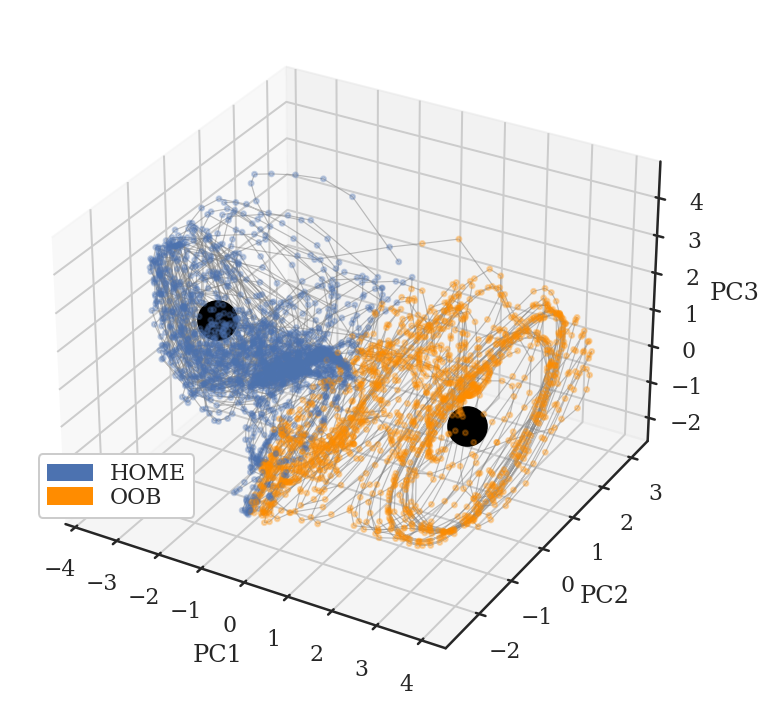

Saving: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed3307e9//report_common_subspace//comsub_by_centroid_3307e9.png


<Figure size 432x288 with 0 Axes>

In [18]:
# %config InlineBackend.figure_format = 'retina'
# mpl.rcParams['figure.dpi'] = 300


n_background = 5
n_color = 1
plot_df = selected_df.groupby(['dataset', 'outcome']).tail(n_background)

fig = plt.figure(figsize=pca3d_figsize)
# fig = plt.figure(figsize=(4,7))
ax = fig.gca(projection='3d')

# outcome_colormap['HOME'] = 'lightblue'
# outcome_colormap['HOME'] = 'b'
importlib.reload(config)
ttcs_colormap = config.ttcs_colormap

# Doesn't respect this!
# https://matplotlib.org/3.3.3/gallery/misc/zorder_demo.html
    
# # plot centroids
# for h_outcome in hx_centroids.keys():
#     X_pca = pca_common.transform(hx_centroids[h_outcome])
#     ax.scatter(X_pca[0, 0], X_pca[0, 1], X_pca[0, 2], alpha=1.0, 
#        c='black', marker='x', lw=3, s=300, zorder=10) 

    
for idx, row in plot_df.iterrows():
    outcome = row['outcome']
    ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
    traj_df = log_analysis.get_traj_df(row['log'], 
            extended_metadata=False, squash_action=False, seed=model_seed)

    X_pca = pca_common.transform(ep_activity)
    ax.plot(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
            linewidth=0.6, c='grey', alpha=0.5, zorder=1)

    # Add scatterplot colored by distance to centroids
    colors = pd.Series(['grey']*X_pca.shape[0])
    dist_home = np.linalg.norm(ep_activity - hx_centroids['HOME'], axis=1)
    dist_oob = np.linalg.norm(ep_activity - hx_centroids['OOB'], axis=1)
#     colors = pd.Series(outcome_colormap.values())[ dist_home < dist_oob ]
    closer_to_home = [ dist_home[i] < dist_oob[i] for i in range(dist_home.shape[0]) ] 
    colors = [ ttcs_colormap['HOME'] if x else ttcs_colormap['OOB'] for x in closer_to_home ]
#     for h_outcome in hx_centroids.keys():
#         distances = np.linalg.norm(ep_activity - hx_centroids[h_outcome], axis=1)
#         in_range_idxs = distances <= centroid_ranges[h_outcome]
#         colors[ in_range_idxs ] = outcome_colormap[h_outcome]
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
               c=colors, alpha=0.3, s=6, zorder=1)

# plot centroids
for h_outcome in hx_centroids.keys():
    X_pca = pca_common.transform(hx_centroids[h_outcome])
    ax.scatter(X_pca[0, 0], X_pca[0, 1], X_pca[0, 2], alpha=1.0, 
       c='black', marker='o', lw=3, s=300, zorder=10) 

# legend
handles, labels = plt.gca().get_legend_handles_labels()
patch1 = mpatches.Patch(color=ttcs_colormap['HOME'], label='HOME')   
patch2 = mpatches.Patch(color=ttcs_colormap['OOB'], label='OOB')   
handles.extend([patch1, patch2])
plt.legend(handles=handles, 
           loc='lower left', 
           framealpha=1.0,
           labelspacing=0.07,
           bbox_to_anchor=(0.02, 0.24),
          )

ax.set_xlabel(f'PC1')
ax.set_ylabel(f'PC2')
ax.set_zlabel(f'PC3')

# ax.set_xlabel(f'PC1 (VarExp: {pca_common.explained_variance_ratio_[0]:0.2f})')
# ax.set_ylabel(f'PC2 (VarExp: {pca_common.explained_variance_ratio_[1]:0.2f})')
# ax.set_zlabel(f'PC3 (VarExp: {pca_common.explained_variance_ratio_[2]:0.2f})')
# if not batchmode:
#     plt.title(f"{model_seed}")
plt.tight_layout()
plt.show()

fname = f"{outdir}/comsub_by_centroid_{model_seed}.png"
print("Saving:", fname)
plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')

## Floris Q: Time to cast vs time to surge

### Time to cast

In [19]:
# Find episodes that end in casting (OOB)
# Find time from last_enc=0 to entry into OOB-centroid-range
# However, should have encountered plume at least once i.e. last_enc=0 for multiple rows

# for idx, row in plot_df.query("outcome == 'OOB' and dataset == 'constantx5b5' ").iterrows():
#     outcome = row['outcome']
#     ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
#     traj_df = log_analysis.get_traj_df(row['log'], 
#             extended_metadata=False, squash_action=False, seed=model_seed)
#     if sum(traj_df.odor_lastenc == 0) > 1: # encountered plume at least once
#         print("Found")
#         break

In [20]:
# # centroid_ranges = {'HOME':dist_between_centroids/3, 'OOB':dist_between_centroids/3}
# centroid_ranges = {'HOME':dist_between_centroids/2, 'OOB':dist_between_centroids/2}


# home_distances = np.linalg.norm(ep_activity - hx_centroids['HOME'], axis=1)
# oob_distances = np.linalg.norm(ep_activity - hx_centroids['OOB'], axis=1)
# oob_distances

# # TODO fix -- Hack to get plot scales same
# max_val = np.max( [np.max(home_distances), np.max(oob_distances)] )
# max_val
# # np.max(home_distances)

# min_val = np.min( [np.min(home_distances), np.min(oob_distances)] )
# print(min_val, max_val)
# # 
# # pd.Series(home_distances).describe(), pd.Series(oob_distances).describe()

# pd.Series(home_distances).hist(alpha=0.5) # Blue
# pd.Series(oob_distances).hist(alpha=0.5) # Orange
# plt.show()

# exit_idx = len(traj_df.odor_01) - pd.Series(traj_df.odor_01).iloc[::-1].argmax()
# print(exit_idx)

# pd.Series(home_distances).plot(figsize=(5, 1.5), label=r'd$_{HOME}$') # Blue
# pd.Series(oob_distances).plot(label=r'd$_{OOB}$') # Orange
# for x in ['HOME', 'OOB']:
#     plt.axhline(y=centroid_ranges[x], c='grey', ls='--')
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.legend()
# plt.show()

# pd.Series(traj_df.odor_lastenc).plot(figsize=(5, 1))
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.show()

# pd.Series(traj_df.odor_01).plot(figsize=(5, 1))
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.show()

# agent_analysis.visualize_episodes([row['log']], 
#           zoom=2, 
#           dataset=row['dataset'],
#           animate=False,
#          )
# plt.show()

# for x in ['HOME', 'OOB']:
#     plt.axhline(y=centroid_ranges[x], c='grey', ls='--')
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.legend()
# plt.show()

# pd.Series(traj_df.odor_lastenc).plot(figsize=(5, 1))
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.show()

# pd.Series(traj_df.odor_01).plot(figsize=(5, 1))
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.show()

# agent_analysis.visualize_episodes([row['log']], 
#     zoom=2, 
#     dataset=row['dataset'],
#     animate=False,
#     )
# plt.show()

In [21]:
# pd.Series(traj_df.odor_01).plot(figsize=(5, 1))
# exit_idx = len(traj_df.odor_01) - pd.Series(traj_df.odor_01).iloc[::-1].argmax()
# print(exit_idx)
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.show()

In [22]:
# # Distances in PCA space? -- Basically the same

# ep_pca = pca_common.transform(ep_activity)
# hx_centroids_pca = {}
# for h_outcome in hx_centroids.keys():
#     hx_centroids_pca[h_outcome] = pca_common.transform(hx_centroids[h_outcome])

# home_distances = np.linalg.norm(ep_pca - hx_centroids_pca['HOME'], axis=1)
# oob_distances = np.linalg.norm(ep_pca - hx_centroids_pca['OOB'], axis=1)

# # TODO fix -- Hack to get scales same
# max_val = np.max( [np.max(home_distances), np.max(oob_distances)] )
# min_val = np.min( [np.min(home_distances), np.min(oob_distances)] )
# print(min_val, max_val)

# pd.Series(home_distances).hist(alpha=0.5) # Blue
# pd.Series(oob_distances).hist(alpha=0.5) # Orange
# plt.show()

# pd.Series(home_distances).plot(figsize=(5, 1.5))
# pd.Series(oob_distances).plot() # Orange

In [23]:
# # traj_df.loc[:, ['loc_x', 'loc_y']]
# # plt.plot(traj_df['loc_x'], traj_df['loc_y'])
# agent_analysis.visualize_episodes([row['log']], 
#                           zoom=2, 
#                           dataset=row['dataset'],
#                           animate=False,
#                           colorby=home_distances,
#                           vmax=max_val,
#                          )

# agent_analysis.visualize_episodes([row['log']], 
#                           zoom=2, 
#                           dataset=row['dataset'],
#                           animate=False,
#                           colorby=oob_distances,
#                           vmax=max_val,
#                          )

### Time to surge

In [24]:
# # Find episodes that end in HOME
# # Do a hist. of last_enc_max
# # If bimodal, choose episodes with longer duration mode; 
# #   else arbitrary threshold
# # Find trajectory snippets from last_enc.diff()<0, to 15(?) timesteps...
# # .... and look for entry into the HOME-centroid-range

# last_encs = []
# # for idx, row in selected_df.query("outcome == 'HOME' and dataset == 'constantx5b5' ").iterrows():
# for idx, row in plot_df.query("outcome == 'HOME' and dataset == 'constantx5b5' ").iterrows():
#     outcome = row['outcome']
#     ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
#     traj_df = log_analysis.get_traj_df(row['log'], 
#             extended_metadata=False, squash_action=False, seed=model_seed)
# #     last_encs.extend( traj_df.odor_lastenc.to_list() )
#     last_encs.append( traj_df.odor_lastenc.max() )
# pd.Series(last_encs).hist() # Not bimodal for plot_df, but is for selected_df

In [25]:
# last_encs = []
# # for idx, row in selected_df.query("outcome == 'HOME' and dataset == 'constantx5b5' ").iterrows():
# for idx, row in plot_df.query("outcome == 'HOME' and dataset == 'constantx5b5' ").iterrows():
#     outcome = row['outcome']
#     ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
#     traj_df = log_analysis.get_traj_df(row['log'], 
#             extended_metadata=False, squash_action=False, seed=model_seed)

#     if sum(traj_df.odor_lastenc >= 25) >= 1:
#         print("Found", idx)
#         break
        
# pd.Series(traj_df.odor_lastenc).plot(figsize=(5, 1)); plt.show()
# pd.Series(traj_df.odor_01).plot(figsize=(5, 1)); plt.show()

In [26]:
# home_distances = np.linalg.norm(ep_activity - hx_centroids['HOME'], axis=1)
# oob_distances = np.linalg.norm(ep_activity - hx_centroids['OOB'], axis=1)
# oob_distances

# # TODO fix -- Hack to get scales same
# max_val = np.max( [np.max(home_distances), np.max(oob_distances)] )
# min_val = np.min( [np.min(home_distances), np.min(oob_distances)] )
# print(min_val, max_val)

# pd.Series(home_distances).hist(alpha=0.5) # Blue
# pd.Series(oob_distances).hist(alpha=0.5) # Orange
# plt.show()

In [27]:
# entry_idx = traj_df.odor_lastenc.argmax()
# print("entry_idx", entry_idx)


# pd.Series(home_distances).plot(figsize=(5, 1.5), label='d[HOME]') # Blue
# pd.Series(oob_distances).plot(label=r'd$_{OOB}$') # Orange
# for x in ['HOME', 'OOB']:
#     plt.axhline(y=centroid_ranges[x], c='grey', ls='--')
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.legend()
# plt.show()

# # pd.Series(home_distances).plot(figsize=(5, 1.5))
# # pd.Series(oob_distances).plot() # Orange
# # for x in ['HOME', 'OOB']:
# #     plt.axhline(y=centroid_ranges[x], c='grey', ls='--')
# # plt.axvline(x=entry_idx, c='grey', ls=':')
# # plt.show()

# pd.Series(traj_df.odor_lastenc).plot(figsize=(5, 1)) 
# plt.axvline(x=entry_idx, c='grey', ls=':')
# plt.show()

# pd.Series(traj_df.odor_01).plot(figsize=(5, 1))
# plt.axvline(x=entry_idx, c='grey', ls=':')
# plt.show()) # Orange
# for x in ['HOME', 'OOB']:
#     plt.axhline(y=centroid_ranges[x], c='grey', ls='--')
# plt.axvline(x=exit_idx, c='grey', ls=':')
# plt.legend()
# plt.show()

# # pd.Series(home_distances).plot(figsize=(5, 1.5))
# # pd.Series(oob_distances).plot() # Orange
# # for x in ['HOME', 'OOB']:
# #     plt.axhline(y=centroid_ranges[x], c='grey', ls='--')
# # plt.axvline(x=entry_idx, c='grey', ls=':')
# # plt.show()

# pd.Series(traj_df.odor_lastenc).plot(figsize=(5, 1)) 
# plt.axvline(x=entry_idx, c='grey', ls=':')
# plt.show()

# pd.Series(traj_df.odor_01).plot(figsize=(5, 1))
# plt.axvline(x=entry_idx, c='grey', ls=':')
# plt.show()

In [28]:
# # home_distances[entry_idx-3:entry_idx+4]
# pd.Series(home_distances).diff().plot(figsize=(5, 1.5))
# pd.Series(oob_distances).diff().plot() # Orange

In [29]:
# agent_analysis.visualize_episodes([row['log']], 
#                           zoom=2, 
#                           dataset=row['dataset'],
#                           animate=False,
#                           colorby=home_distances,
#                           vmax=max_val,
#                          )

# agent_analysis.visualize_episodes([row['log']], 
#                           zoom=2, 
#                           dataset=row['dataset'],
#                           animate=False,
#                           colorby=oob_distances,
#                           vmax=max_val,
#                          )

### Scale out TTC and TTS

In [30]:
# Work with all episodes
use_datasets_all = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']
all_df = log_analysis.get_selected_df(model_dir, 
                              use_datasets_all, 
                              n_episodes_home=240, 
                              n_episodes_other=240,
                              balanced=False,
                              oob_only=False,
                              min_ep_steps=0)

In [31]:
# all_df.groupby(['dataset','outcome']).count()
all_df.groupby(['dataset']).count()

,idx,ep_length,log,outcome
dataset,,,,
constantx5b5,240,240,240,240
noisy3x5b5,240,240,240,240
switch45x5b5,240,240,240,240


In [32]:
# Common
centroid_ranges = {'HOME':dist_between_centroids/2, 'OOB':dist_between_centroids/2}
datasets = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']
# datasets = ['constantx5b5']
# datasets = ['constantx5b5_0.4']
# datasets = use_datasets

to_plot = []
# to_plot = ['distances']
# to_plot = ['trajectories']
# to_plot = ['distances', 'trajectories']

print(datasets)
print(to_plot)

['constantx5b5', 'switch45x5b5', 'noisy3x5b5']
[]


In [33]:
# Scale out time-to-cast

ttc_df = [] # time to cast
snippet_window = 10 # steps

# 1. Select eps that end in OOB
for idx, row in all_df.query("outcome != 'HOME' and dataset in @datasets ").iterrows():
    outcome = row['outcome']
    dataset = row['dataset']    
    ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
    traj_df = log_analysis.get_traj_df(row['log'], 
            extended_metadata=True, squash_action=True, seed=model_seed)
    
    # 2: ep. encountered plume at least X timesteps before RECOVER/LOST
    min_steps_on_plume = 2 # 1 step is trivially possible because odor_lastenc[0]==0 :(
    steps_on_plume = sum(traj_df.odor_lastenc == 0)
    if steps_on_plume < min_steps_on_plume:
        print(f"{idx}: steps_on_plume {steps_on_plume} < {min_steps_on_plume}")
        continue
        
    # 3: Get (last) exit_idx
    exit_length = pd.Series(traj_df.odor_01).iloc[::-1].argmax()
    ep_length = len(traj_df.odor_01)
    ep_len = traj_df.shape[0]
    exit_idx = ep_length - exit_length
    print(ep_length, exit_idx, exit_length, steps_on_plume)
    if exit_length < 25: # exclude episodes where it exits too close to end of episode
        print(f"{idx}: exit_lenght {exit_length}")

        
    # 4: Get idx of when gets into OOB range
    home_distances = np.linalg.norm(ep_activity - hx_centroids['HOME'], axis=1)
    oob_distances = np.linalg.norm(ep_activity - hx_centroids['OOB'], axis=1)

    oob_idx = pd.Series(oob_distances > centroid_ranges['OOB'])
    oob_idx[:exit_idx] = True
    oob_idx = oob_idx.argmin()

    ttc = oob_idx - exit_idx
    if ttc <= 0: # automation failure -- outlier cases where episodes ends before entering OOB
        continue

    if 'distances' in to_plot:
        pd.Series(home_distances).plot(figsize=(5, 1.5), label=r'd$_{HOME}$') # Blue
        pd.Series(oob_distances).plot(label=r'd$_{OOB}$') # Orange
        for x in ['HOME', 'OOB']:
            plt.axhline(y=centroid_ranges[x], c='grey', ls='--')
        plt.axvline(x=exit_idx, c='black', ls=':')
        plt.axvline(x=oob_idx, c='orange', ls='--')
        plt.title(row['idx'])
        plt.legend()
        plt.show()

    if 'trajectories' in to_plot:
        agent_analysis.visualize_episodes([row['log']], 
                  zoom=2, 
                  dataset=row['dataset'],
                  animate=False,
                 )
        plt.show()


    ttc_df.append({ 
                    'idx': row['idx'],
                    'ep_len': ep_len,
                    'outcome': outcome,
                    'dataset': dataset,
                    'exit_idx': exit_idx,
                    'entry_idx': None,     
                    'oob_idx': oob_idx,
                    'home_idx': None,
                    'ttc':  ttc,
                    'tts': None,
                    'range_oob': centroid_ranges['OOB'],
                    'range_home': centroid_ranges['HOME'],
#                         'log': row['log'],
                    'entered_search_mode': True, # for all OOB
                    'speed_snippet': traj_df['r_step'][exit_idx-snippet_window:exit_idx+snippet_window+1].to_list(),
                    'traj_snippet': traj_df.iloc[exit_idx-snippet_window:exit_idx+snippet_window+1,:],
                    'home_distances': home_distances,
                    'oob_distances': oob_distances,
                   })

ttc_df = pd.DataFrame(ttc_df)
print(ttc_df.shape)
ttc_df.head() # Orange

seed specific thresholds 12 35
299 277 22 36
300: exit_lenght 22
seed specific thresholds 12 35
299 266 33 43
seed specific thresholds 12 35
299 271 28 75
seed specific thresholds 12 35
299 100 199 11
seed specific thresholds 12 35
299 213 86 64
seed specific thresholds 12 35
299 273 26 21
seed specific thresholds 12 35
299 297 2 104
306: exit_lenght 2
seed specific thresholds 12 35
299 283 16 9
307: exit_lenght 16
seed specific thresholds 12 35
299 272 27 18
seed specific thresholds 12 35
299 288 11 34
309: exit_lenght 11
seed specific thresholds 12 35
299 281 18 13
310: exit_lenght 18
seed specific thresholds 12 35
311: steps_on_plume 1 < 2
seed specific thresholds 12 35
299 280 19 12
312: exit_lenght 19
seed specific thresholds 12 35
299 297 2 15
313: exit_lenght 2
seed specific thresholds 12 35
299 297 2 35
314: exit_lenght 2
seed specific thresholds 12 35
299 299 0 102
315: exit_lenght 0
seed specific thresholds 12 35
299 290 9 38
316: exit_lenght 9
seed specific thresholds 12 35


299 225 74 76
seed specific thresholds 12 35
299 298 1 68
446: exit_lenght 1
seed specific thresholds 12 35
447: steps_on_plume 1 < 2
seed specific thresholds 12 35
299 298 1 92
448: exit_lenght 1
seed specific thresholds 12 35
299 298 1 45
449: exit_lenght 1
seed specific thresholds 12 35
299 297 2 55
450: exit_lenght 2
seed specific thresholds 12 35
299 208 91 85
seed specific thresholds 12 35
299 207 92 80
seed specific thresholds 12 35
299 165 134 9
seed specific thresholds 12 35
299 181 118 91
seed specific thresholds 12 35
299 228 71 4
seed specific thresholds 12 35
299 185 114 99
seed specific thresholds 12 35
299 275 24 11
457: exit_lenght 24
seed specific thresholds 12 35
299 181 118 97
seed specific thresholds 12 35
299 243 56 17
seed specific thresholds 12 35
460: steps_on_plume 1 < 2
seed specific thresholds 12 35
299 295 4 77
461: exit_lenght 4
seed specific thresholds 12 35
299 204 95 79
seed specific thresholds 12 35
299 263 36 8
seed specific thresholds 12 35
299 182 11

180 55 125 7
seed specific thresholds 12 35
178 113 65 6
seed specific thresholds 12 35
178 62 116 11
seed specific thresholds 12 35
176 78 98 25
seed specific thresholds 12 35
607: steps_on_plume 1 < 2
seed specific thresholds 12 35
175 95 80 3
seed specific thresholds 12 35
609: steps_on_plume 1 < 2
seed specific thresholds 12 35
610: steps_on_plume 1 < 2
seed specific thresholds 12 35
611: steps_on_plume 1 < 2
seed specific thresholds 12 35
171 55 116 6
seed specific thresholds 12 35
613: steps_on_plume 1 < 2
seed specific thresholds 12 35
169 169 0 54
614: exit_lenght 0
seed specific thresholds 12 35
165 99 66 9
seed specific thresholds 12 35
165 165 0 13
616: exit_lenght 0
seed specific thresholds 12 35
617: steps_on_plume 1 < 2
seed specific thresholds 12 35
164 54 110 7
seed specific thresholds 12 35
164 164 0 65
619: exit_lenght 0
seed specific thresholds 12 35
160 61 99 14
seed specific thresholds 12 35
621: steps_on_plume 1 < 2
seed specific thresholds 12 35
159 58 101 11
see

,idx,ep_len,outcome,dataset,exit_idx,entry_idx,oob_idx,home_idx,ttc,tts,range_oob,range_home,entered_search_mode,speed_snippet,traj_snippet,home_distances,oob_distances
0,155,299,OOT,constantx5b5,100,None,127,None,27,None,2.85128,2.85128,True,"[-0.12001384504108259, -0.1060966023271126, -0...",loc_x loc_y t_val wind_theta_obs...,"[4.6869617, 4.77494, 5.002743, 5.101193, 5.027...","[2.7401414, 2.6363251, 2.967686, 3.1071186, 2...."
1,178,299,OOT,noisy3x5b5,213,None,273,None,60,None,2.85128,2.85128,True,"[0.17481000357273846, 0.24109667722513883, 0.2...",loc_x loc_y t_val wind_theta_obs...,"[4.656879, 4.587188, 4.5239234, 4.3984637, 4.1...","[3.2588904, 3.4603086, 3.4820375, 3.6914217, 3..."
2,15,299,OOT,switch45x5b5,4,None,27,None,23,None,2.85128,2.85128,True,[],"Empty DataFrame Columns: [loc_x, loc_y, t_val,...","[4.43136, 4.3401513, 3.8189652, 3.2219028, 2.8...","[2.8468146, 3.4289255, 4.1568394, 4.7694087, 5..."
3,181,299,OOT,constantx5b5,193,None,217,None,24,None,2.85128,2.85128,True,"[-0.13931599206031375, -0.14563351671212477, -...",loc_x loc_y t_val wind_theta_obs...,"[4.199869, 4.207994, 4.2724895, 4.504037, 4.41...","[2.4123712, 2.5787203, 2.7222989, 3.0504284, 3..."
4,180,299,OOT,noisy3x5b5,122,None,139,None,17,None,2.85128,2.85128,True,"[0.014841117581441132, 0.19670576459472233, 0....",loc_x loc_y t_val wind_theta_obs...,"[4.4527, 4.417487, 4.426271, 4.440658, 4.38806...","[2.8695748, 2.950342, 2.966098, 3.16238, 3.196..."


In [34]:
# Scale out time-to-home calculation
tts_df = [] # time to surge
outcome = 'HOME'
last_encs = []

# 1. Only ep that end in HOME
for idx, row in all_df.query("outcome == @outcome and dataset in @datasets ").iterrows():
    outcome = row['outcome']
    dataset = row['dataset']    

    ep_activity = log_analysis.get_activity(row['log'], is_recurrent, do_plot=False)
    traj_df = log_analysis.get_traj_df(row['log'], 
            extended_metadata=True, squash_action=True, seed=model_seed)

    # 2. Only ep. where agent enters RECOVER regime
    min_exit_duration = 13
    if sum(traj_df.odor_lastenc >= min_exit_duration) ==0:
        break
        
    # 3. entry_idx for first instance in ep. where enters from RECOVER (can also be in LOST)
    ep_len = traj_df.shape[0]
    for entry_idx in reversed(range(ep_len)): 
        if traj_df.odor_lastenc[entry_idx] >= min_exit_duration:
            break

    # 4. Locate home_idx i.e. idx when in range of HOME centroid
    home_distances = np.linalg.norm(ep_activity - hx_centroids['HOME'], axis=1)
    oob_distances = np.linalg.norm(ep_activity - hx_centroids['OOB'], axis=1)

    home_idx = pd.Series(home_distances > centroid_ranges[outcome])
    home_idx[:entry_idx] = True # ignore till entry_idx
    home_idx = home_idx.argmin()

    tts = home_idx - entry_idx
    if tts < 0:
        continue # exclude -- ep. identification failure
        
    # 5. Flag for if this ep was in within OOB range before entry_idx
    entered_search_mode = pd.Series(oob_distances < centroid_ranges['OOB'])[:entry_idx].any()
        
        
    if 'distances' in to_plot:
        pd.Series(home_distances).plot(figsize=(5, 1.5), label='d[HOME]') # Blue
        pd.Series(oob_distances).plot(label=r'd$_{OOB}$') # Orange
        for x in ['HOME', 'OOB']:
            plt.axhline(y=centroid_ranges[x], c='grey', ls='--')
        plt.axvline(x=entry_idx, c='grey', ls=':')
        plt.axvline(x=home_idx, c='b', ls='--')
        plt.title(row['idx'])
        plt.legend()
        plt.show()

    if 'trajectories' in to_plot:            
        agent_analysis.visualize_episodes([row['log']], 
                          zoom=2, 
                          dataset=row['dataset'],
                          animate=False,
                         )
        plt.show()


    tts_df.append({ 
        'idx': row['idx'],
        'ep_len': ep_len,
        'outcome': outcome,
        'dataset': dataset,
        'exit_idx': None,
        'entry_idx': entry_idx,     
        'oob_idx': None,
        'home_idx': home_idx,
        'ttc':  None,
        'tts': tts,
        'range_oob': centroid_ranges['OOB'],
        'range_home': centroid_ranges['HOME'],
        'entered_search_mode': entered_search_mode,
        'traj_snippet': traj_df.iloc[entry_idx-snippet_window:entry_idx+snippet_window+1,:],
        'speed_snippet': traj_df['r_step'][entry_idx-snippet_window:entry_idx+snippet_window+1].to_list(),
#                     'log': row['log'],
        'home_distances': home_distances,
        'oob_distances': oob_distances,
       })

tts_df = pd.DataFrame(tts_df)
print(tts_df.shape)
tts_df.head() 

seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed specific thresholds 12 35
seed spe

,idx,ep_len,outcome,dataset,exit_idx,entry_idx,oob_idx,home_idx,ttc,tts,range_oob,range_home,entered_search_mode,traj_snippet,speed_snippet,home_distances,oob_distances
0,212,288,HOME,switch45x5b5,None,184,None,218,None,34,2.85128,2.85128,False,loc_x loc_y t_val wind_theta_obs...,"[-0.46454335964055016, -0.38290636035700487, -...","[4.8250117, 4.641564, 4.3980193, 4.1935205, 3....","[3.3812294, 3.4953115, 3.4325461, 3.6518726, 3..."
1,238,287,HOME,noisy3x5b5,None,228,None,232,None,4,2.85128,2.85128,False,loc_x loc_y t_val wind_theta_obs...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.5756702, 4.3073196, 4.0373693, 3.8730383, 3...","[2.8720188, 2.9594798, 3.209172, 3.3934503, 3...."
2,34,286,HOME,noisy3x5b5,None,202,None,209,None,7,2.85128,2.85128,True,loc_x loc_y t_val wind_theta_obs...,"[-0.10484499457545926, -0.10226832668350117, -...","[3.778248, 3.1190197, 2.4495175, 2.9623525, 3....","[2.8437948, 3.921897, 5.293078, 6.737966, 7.20..."
3,82,285,HOME,constantx5b5,None,193,None,205,None,12,2.85128,2.85128,True,loc_x loc_y t_val wind_theta_obs...,"[-0.3033186017698464, -0.17068016097835148, -0...","[4.2645063, 3.835578, 3.5814483, 3.5735607, 3....","[2.835534, 2.9199195, 3.2000496, 3.6505404, 3...."
4,228,285,HOME,switch45x5b5,None,181,None,224,None,43,2.85128,2.85128,True,loc_x loc_y t_val wind_theta_obs...,"[-0.4383585104175225, -0.3402972486453981, -0....","[4.6611967, 4.4187284, 4.17376, 4.2097297, 4.2...","[2.856365, 2.7841315, 2.782242, 2.9574263, 3.1..."


In [35]:
# Histograms
# plt.figure(figsize=(5,3))
# tts_df['tts'][~tts_df.entered_search_mode].hist(label='tts_nosearch', alpha=0.5)
# tts_df['tts'][tts_df.entered_search_mode].hist(label='tts_search', alpha=0.5)
# ttc_df['ttc'].hist(label='ttc', alpha=0.5)
# plt.legend()
# plt.title(f'Time to cast/surge [Seed:{model_seed}]')
# plt.tight_layout()
# fname = f"{outdir}/ttcs_hist_{model_seed}.png"
# print("Saving:", fname)
# plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
# plt.show()

In [36]:
# Swarmplot
ttc_df['label'] = 'TTL'
ttc_df['timesteps'] = ttc_df['ttc']
tts_df['label'] = 'TTT-L'
tts_df['timesteps'] = tts_df['tts']
tts_df['label'][~tts_df.entered_search_mode] = 'TTT-NL'
ttcs_df = pd.concat([tts_df, ttc_df])
ttcs_df.to_csv(f"{outdir}/ttcs_swarm_{model_seed}.csv")
ttcs_df.to_pickle(f"{outdir}/ttcs_swarm_{model_seed}.pkl")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TTT-L v.s. TTL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.323e-12 U_stat=3.095e+02
TTT-NL v.s. TTT-L: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.448e-01 U_stat=1.820e+02
TTT-NL v.s. TTL: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.353e-08 U_stat=1.015e+02


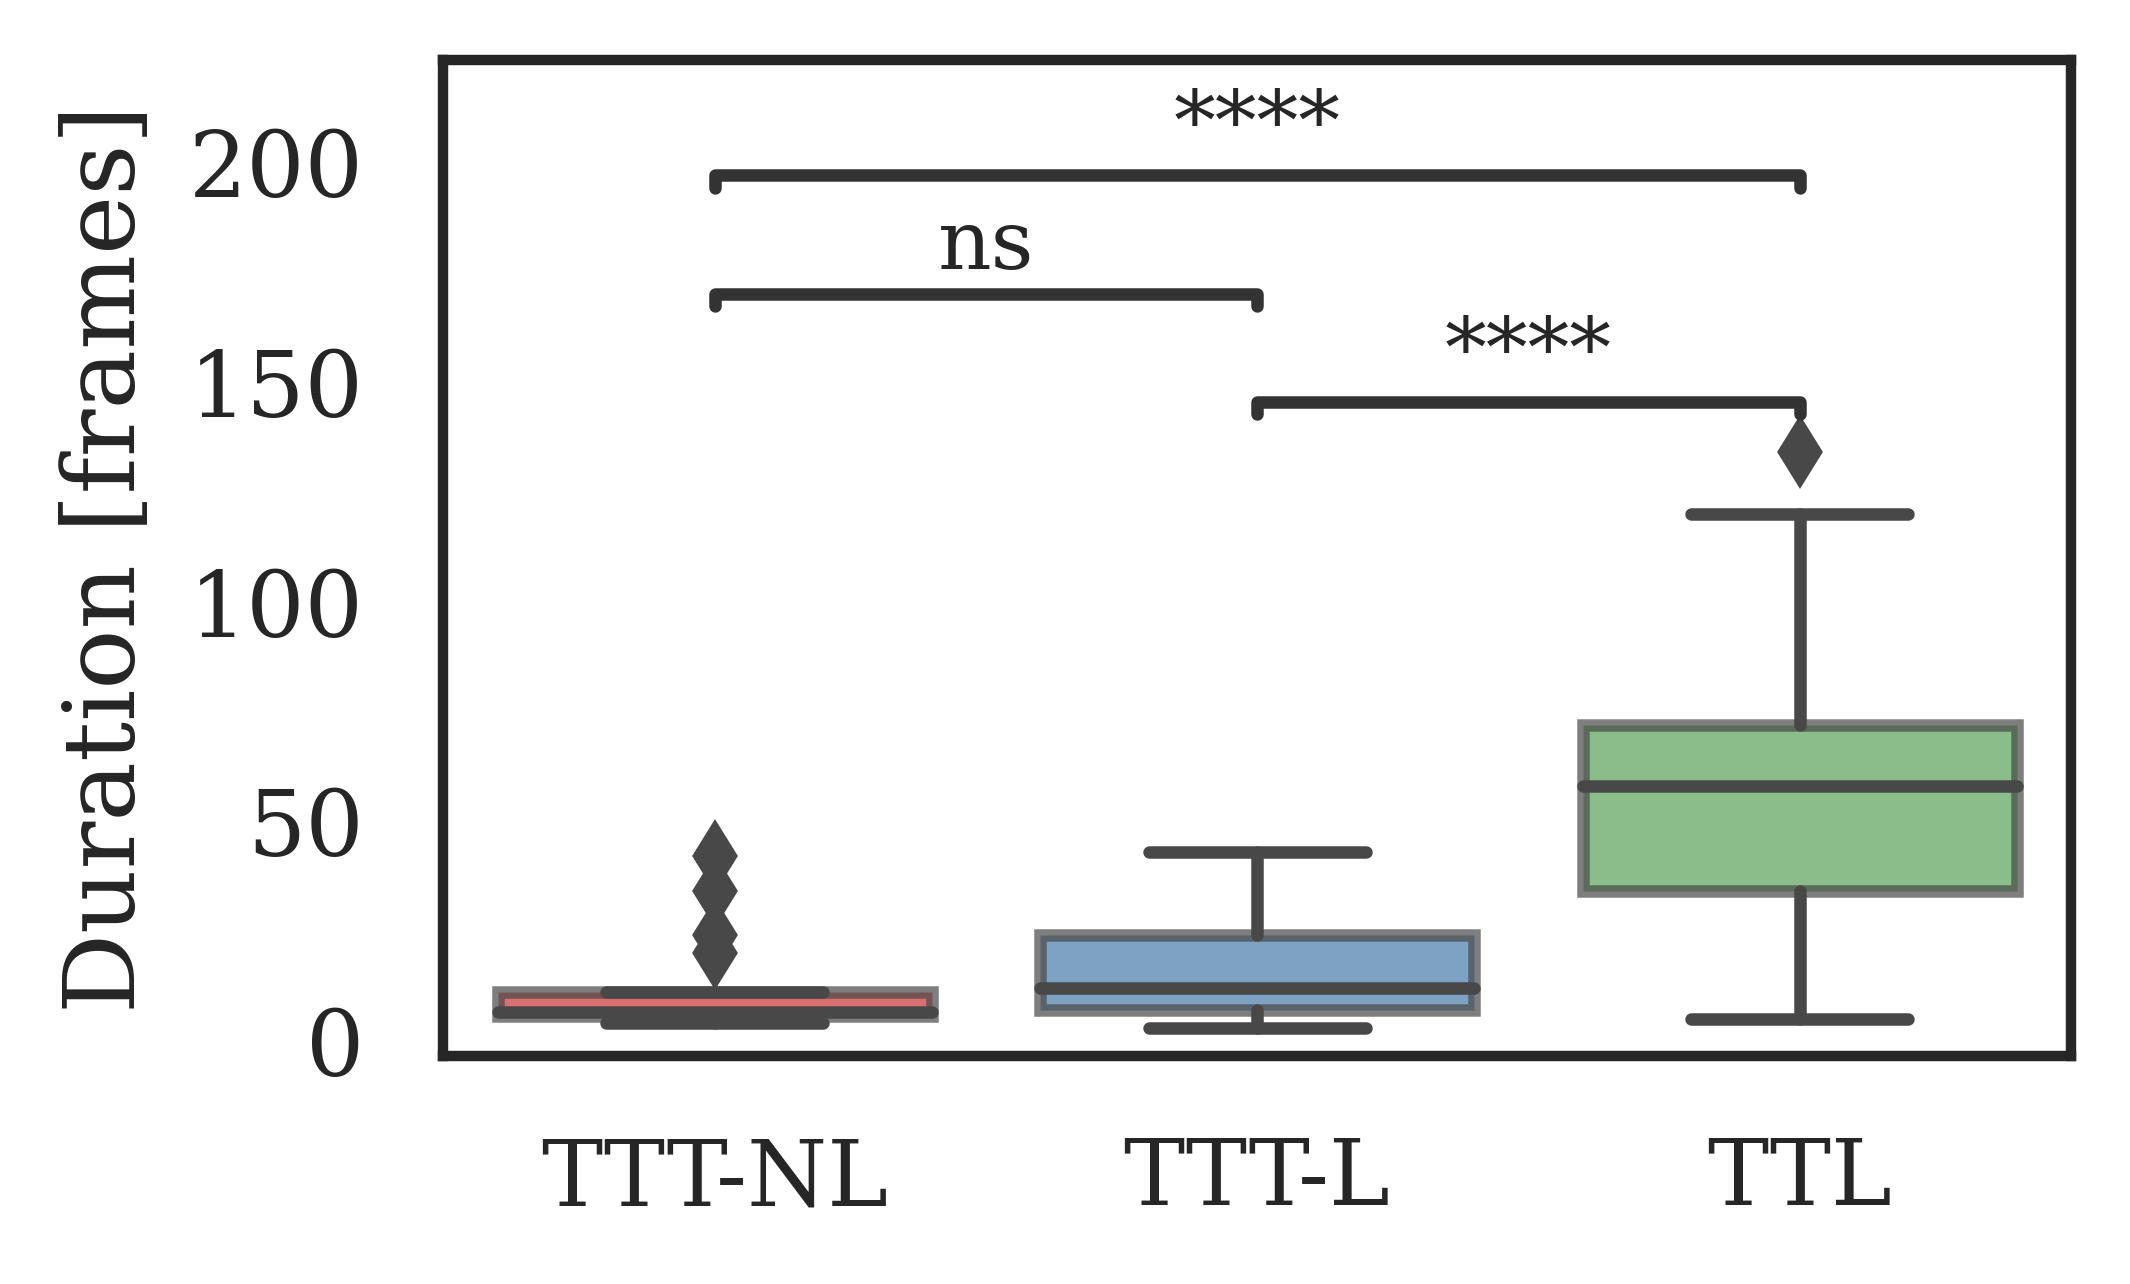

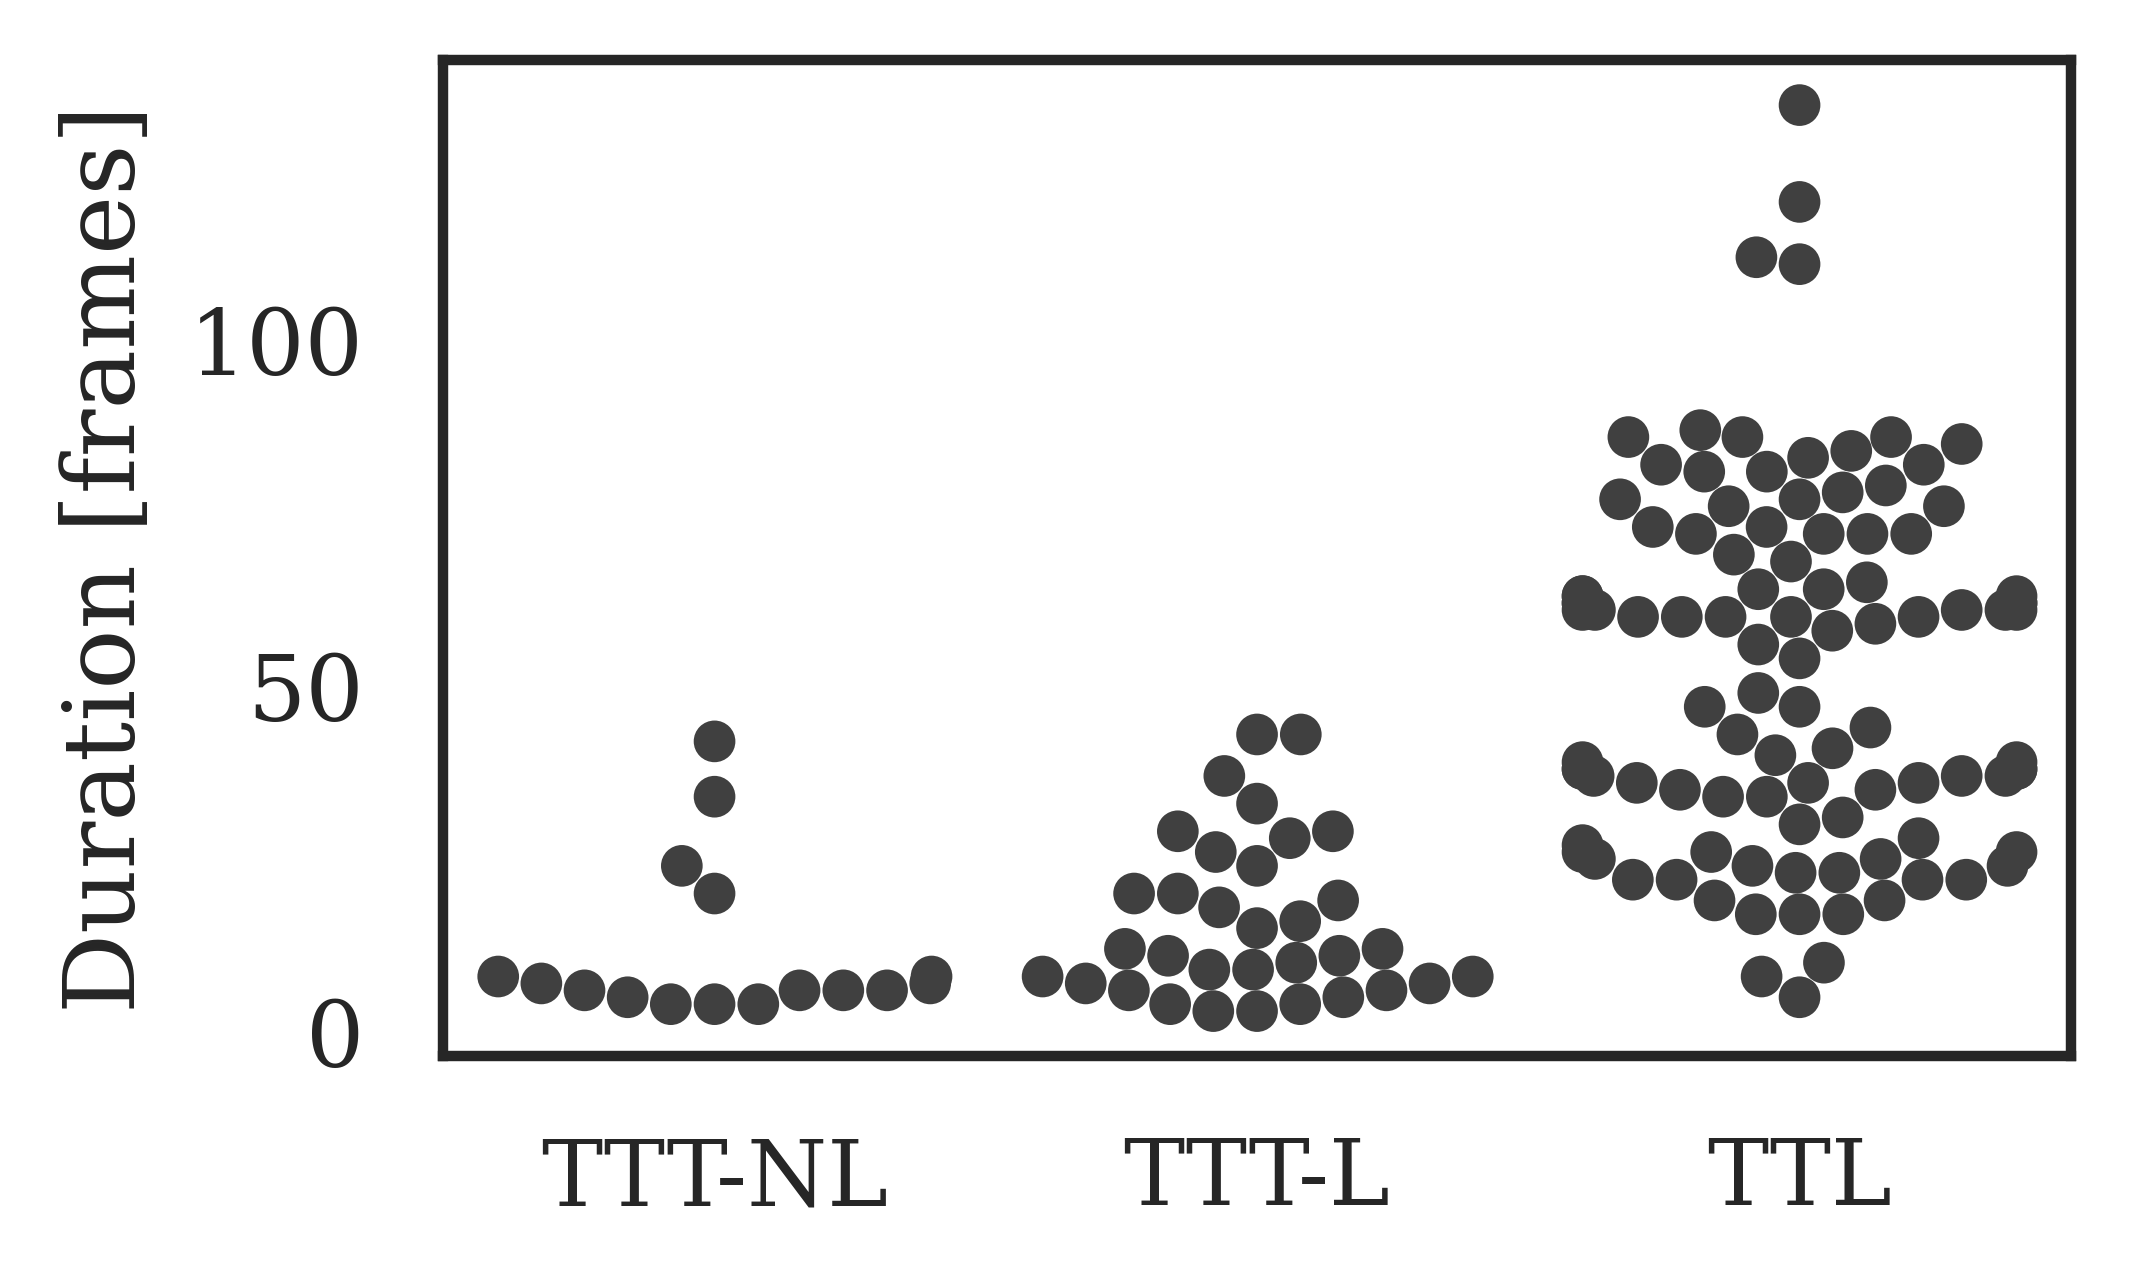

In [47]:
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 300


figsz = (3.5,2.2)
# figsz = (3,2)


# Original w/o statannot
# plt.figure(figsize=figsz)
# ax = sns.boxplot(x="label", y="timesteps", data=ttcs_df, palette="Set1")
# # plt.title(f"{datasets} [Seed:{model_seed}]")
# if not batchmode:
#     plt.title(f"[Seed:{model_seed}]")
# plt.tight_layout()
# plt.ylabel("Duration [frames]")
# plt.xlabel(None)
# plt.savefig(f"{outdir}/ttcs_box_{model_seed}.png", dpi=dpi_save, bbox_inches='tight')
# plt.show()

sns.color_palette()
# sns.color_palette("pastel")
# sns.set_palette("pastel")

from statannot import add_stat_annotation
plt.figure(figsize=figsz)
order = ["TTT-NL", "TTT-L", "TTL"]
ax = sns.boxplot(x="label", 
                 y="timesteps", 
                 data=ttcs_df, 
                 order=order,
                 palette="Set1",
                 boxprops=dict(alpha=.7),
                )
# plt.title(f"{datasets} [Seed:{model_seed}]")
test_results = add_stat_annotation(ax, data=ttcs_df, 
                                   x="label", 
                                   y="timesteps", 
                                   order=order,
                                   box_pairs=[
                                       ("TTT-L", "TTL"),
                                       ("TTT-NL", "TTL"), 
                                       ("TTT-NL", "TTT-L"),], 
                                   test='Mann-Whitney', text_format='star',
                                   loc='inside', verbose=2)


# if not batchmode:
#     plt.title(f"[Seed:{model_seed}]")
# plt.tight_layout()
plt.ylabel("Duration [frames]")
plt.xlabel(None)
plt.savefig(f"{outdir}/ttcs_box_{model_seed}.png", dpi=dpi_save, bbox_inches='tight')
plt.show()


#Swarm
plt.figure(figsize=figsz)
ax = sns.swarmplot(x="label", y="timesteps", data=ttcs_df, order=order, color=".25")
# plt.title(f"{datasets} [Seed:{model_seed}]")
plt.xlabel(None)
# if not batchmode:
#     plt.title(f"[Seed:{model_seed}]")
plt.ylabel("Duration [frames]")
# plt.tight_layout()
plt.savefig(f"{outdir}/ttcs_swarm_{model_seed}.png", dpi=dpi_save, bbox_inches='tight')
plt.show()